# FastText

- FastText的原理。
- 利用FastText模型进行文本分类。
- fasttext1 fasttext2 fasttext3 其中的参考


参考学习 https://blog.csdn.net/feilong_csdn/article/details/88655927

## 一、fastText简介
fastText是一个快速文本分类算法，与基于神经网络的分类算法相比有两大优点：
1、fastText在保持高精度的情况下加快了训练速度和测试速度
2、fastText不需要预训练好的词向量，fastText会自己训练词向量
3、fastText两个重要的优化：Hierarchical Softmax、N-gram


##  二、fastText模型架构
fastText模型架构和word2vec中的CBOW很相似， 不同之处是fastText预测标签而CBOW预测的是中间词，即模型架构类似但是模型的任务不同。下面我们先看一下CBOW的架构：

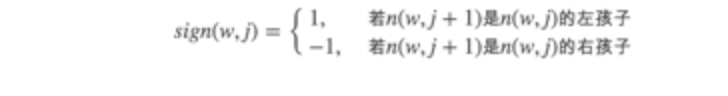

word2vec将上下文关系转化为多分类任务，进而训练逻辑回归模型，这里的类别数量|V|词库大小。通常的文本数据中，词库少则数万，多则百万，在训练中直接训练多分类逻辑回归并不现实。word2vec中提供了两种针对大规模多分类问题的优化手段， negative sampling 和hierarchical softmax。在优化中，negative sampling 只更新少量负面类，从而减轻了计算量。hierarchical softmax 将词库表示成前缀树，从树根到叶子的路径可以表示为一系列二分类器，一次多分类计算的复杂度从|V|降低到了树的高度、

## 三、层次softmax
softmax函数常在神经网络输出层充当激活函数，目的就是将输出层的值归一化到0-1区间，将神经元输出构造成概率分布，主要就是起到将神经元输出值进行归一化的作用，下图展示了softmax函数对于输出值z1=3,z2=1,z3=-3的归一化映射过程



在标准的softmax中，计算一个类别的softmax概率时，我们需要对所有类别概率做归一化，在这类别很大情况下非常耗时，因此提出了分层softmax(Hierarchical Softmax),思想是根据类别的频率构造霍夫曼树来代替标准softmax，通过分层softmax可以将复杂度从N降低到logN，下图给出分层softmax示例：


在层次softmax模型中，叶子结点的词没有直接输出的向量，而非叶子节点都有响应的输在在模型的训练过程中，通过Huffman编码，构造了一颗庞大的Huffman树，同时会给非叶子结点赋予向量。我们要计算的是目标词w的概率，这个概率的具体含义，是指从root结点开始随机走，走到目标词w的概率。因此在途中路过非叶子结点（包括root）时，需要分别知道往左走和往右走的概率。例如到达非叶子节点n的时候往左边走和往右边走的概率分别是：

以上图中目标词为w2为例，

到这里可以看出目标词为w的概率可以表示为：

$$
p(w)=\prod_{j=1}^{L(\omega)-1} \sigma\left(\operatorname{sign}(w, j) \cdot \theta_{n(w, j)}^{T} h\right)
$$

其中θn(w,j)是非叶子结点n(w,j)的向量表示（即输出向量）；h是隐藏层的输出值，从输入词的向量中计算得来；sign(x,j)是一个特殊函数定义



此外，所有词的概率和为1，即

$$
\sum_{i=1}^{n} p\left(w_{i}\right)=1
$$


最终得到参数更新公式为：
$$
\theta_{j}^{(n m)}=\theta_{j}^{(o l i \theta)}-n\left(\sigma\left(\theta_{j}^{T} h\right)-t_{j}\right) h
$$

$$
j=1,2, \ldots, L(w)-1
$$

## 四、N-gram特征
n-gram是基于语言模型的算法，基本思想是将文本内容按照子节顺序进行大小为N的窗口滑动操作，最终形成窗口为N的字节片段序列。而且需要额外注意一点是n-gram可以根据粒度不同有不同的含义，有字粒度的n-gram和词粒度的n-gram，下面分别给出了字粒度和词粒度的例子：


对于文本句子的n-gram来说，如上面所说可以是字粒度或者是词粒度，同时n-gram也可以在字符级别工作，例如对单个单词matter来说，假设采用3-gram特征，那么matter可以表示成图中五个3-gram特征，这五个特征都有各自的词向量，五个特征的词向量和即为matter这个词的向其中“<”和“>”是作为边界符号被添加，来将一个单词的ngrams与单词本身区分开来：


从上面来看，使用n-gram有如下优点
1、为罕见的单词生成更好的单词向量：根据上面的字符级别的n-gram来说，即是这个单词出现的次数很少，但是组成单词的字符和其他单词有共享的部分，因此这一点可以优化生成的单词向量
2、在词汇单词中，即使单词没有出现在训练语料库中，仍然可以从字符级n-gram中构造单词的词向量
3、n-gram可以让模型学习到局部单词顺序的部分信息, 如果不考虑n-gram则便是取每个单词，这样无法考虑到词序所包含的信息，即也可理解为上下文信息，因此通过n-gram的方式关联相邻的几个词，这样会让模型在训练的时候保持词序信息

但正如上面提到过，随着语料库的增加，内存需求也会不断增加，严重影响模型构建速度，针对这个有以下几种解决方案：
1、过滤掉出现次数少的单词
2、使用hash存储
3、由采用字粒度变化为采用词粒度
